# Twitter Sentiment Analysis with BERT

Let's get started!

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:
- watermark: An IPython magic extension for printing date and time stamps, version numbers, and hardware information.
- IPython is an interactive shell that is built with python. It provides a more useful shell environment to execute python code in REPL (Read Eval Print Loop). It makes it more interactive by adding features like syntax highlighting, code completion etc. IPython also comes with other tools like Jupyter Notebooks etc.

In [ ]:
# -q -qq, or -qqq: give less output
# -U: Upgrade all specified packages to the newest available version.
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.5 MB/s eta 0:00:00


In [ ]:
!pip install -qq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 97.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.3 MB/s eta 0:00:00


In [ ]:
# load watermark
# -v: prints Python and IPython version; -p: prints versions of packages
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.23.5
pandas      : 1.5.3
torch       : 2.1.0+cu118
transformers: 4.35.0



In [ ]:
# Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration

We'll load the Twitter Sentiment dataset, that we've put together in the previous part:

In [ ]:
# install gdown first for downloading a large file from Google Drive: pip install gdown
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 113MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 18.6MB/s]


In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/gdrive')

# Load the CSV data from Google Drive
file_path = 'gdrive/My Drive/Colab Notebooks/Twitter project/data/Twitter_Dataset/twitter_training_split.csv'

df = pd.read_csv(file_path)
column_mapping = {'Sentence': 'content', 'Sentiment': 'sentiment'}

# Use the rename method to rename the columns
df = df.rename(columns=column_mapping)

df = df[df['sentiment']!='Irrelevant']
df.dropna(inplace=True)
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,sentiment,content,split
12875,Negative,when i typed this for the first time i was so ...,train
12876,Negative,the fact that i can t speak freely on any big ...,train
12877,Negative,this is the best explanation for my frustratio...,train
12878,Negative,actually kinda sucks that i can t play competi...,train
12879,Negative,this is so disgusting ron k n k beluba pic . s...,train


In [ ]:
df.shape

(38541, 3)

We have about 38k examples. Let's check for missing values:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38541 entries, 12875 to 51499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  38541 non-null  object
 1   content    38541 non-null  object
 2   split      38541 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


Great, no missing values in the data! Do we have class imbalance?

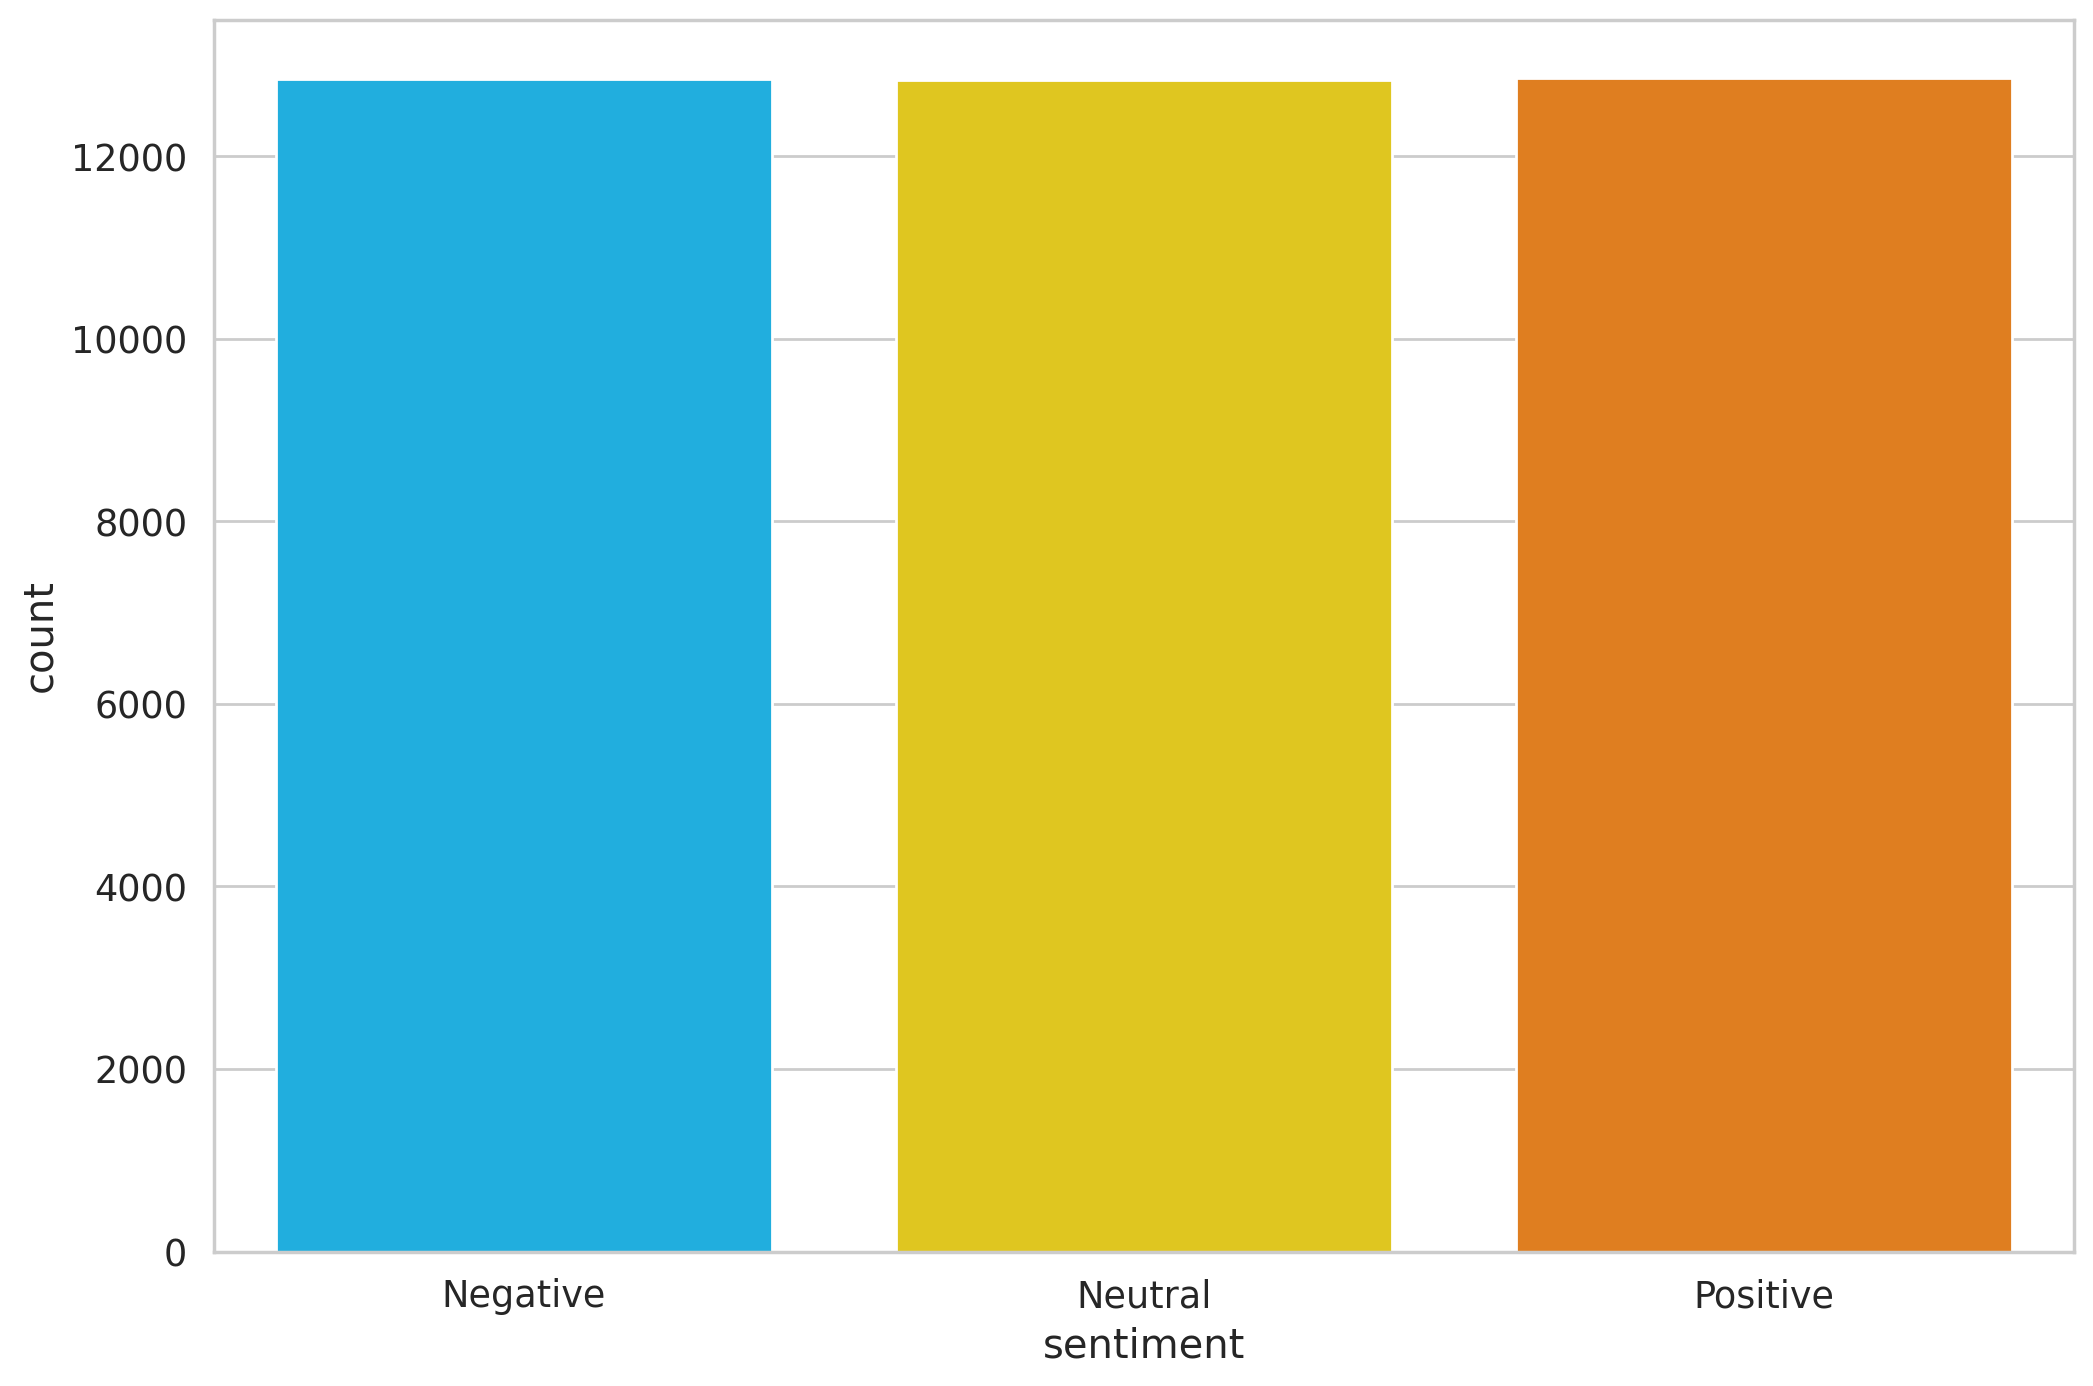

In [ ]:
sns.countplot(x=df.sentiment)
plt.xlabel('sentiment');

In [ ]:
def to_sentiment(rating):
  if rating == 'Negative':
    return 0
  elif rating == "Neutral":
    return 1
  elif rating == "Positive":
    return 2
  else:
    print('Irrelevant')

df['sentiment'] = df.sentiment.apply(to_sentiment)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,sentiment,content,split
0,1,"i would not be the first of observe this , but...",train
1,1,this druggie kid lives from a nearby home conv...,train
2,0,eamaddennfl the guys are a damn joke ! ! !,val
3,0,fifa can be fucking with no body,train
4,2,thank you ! .,train


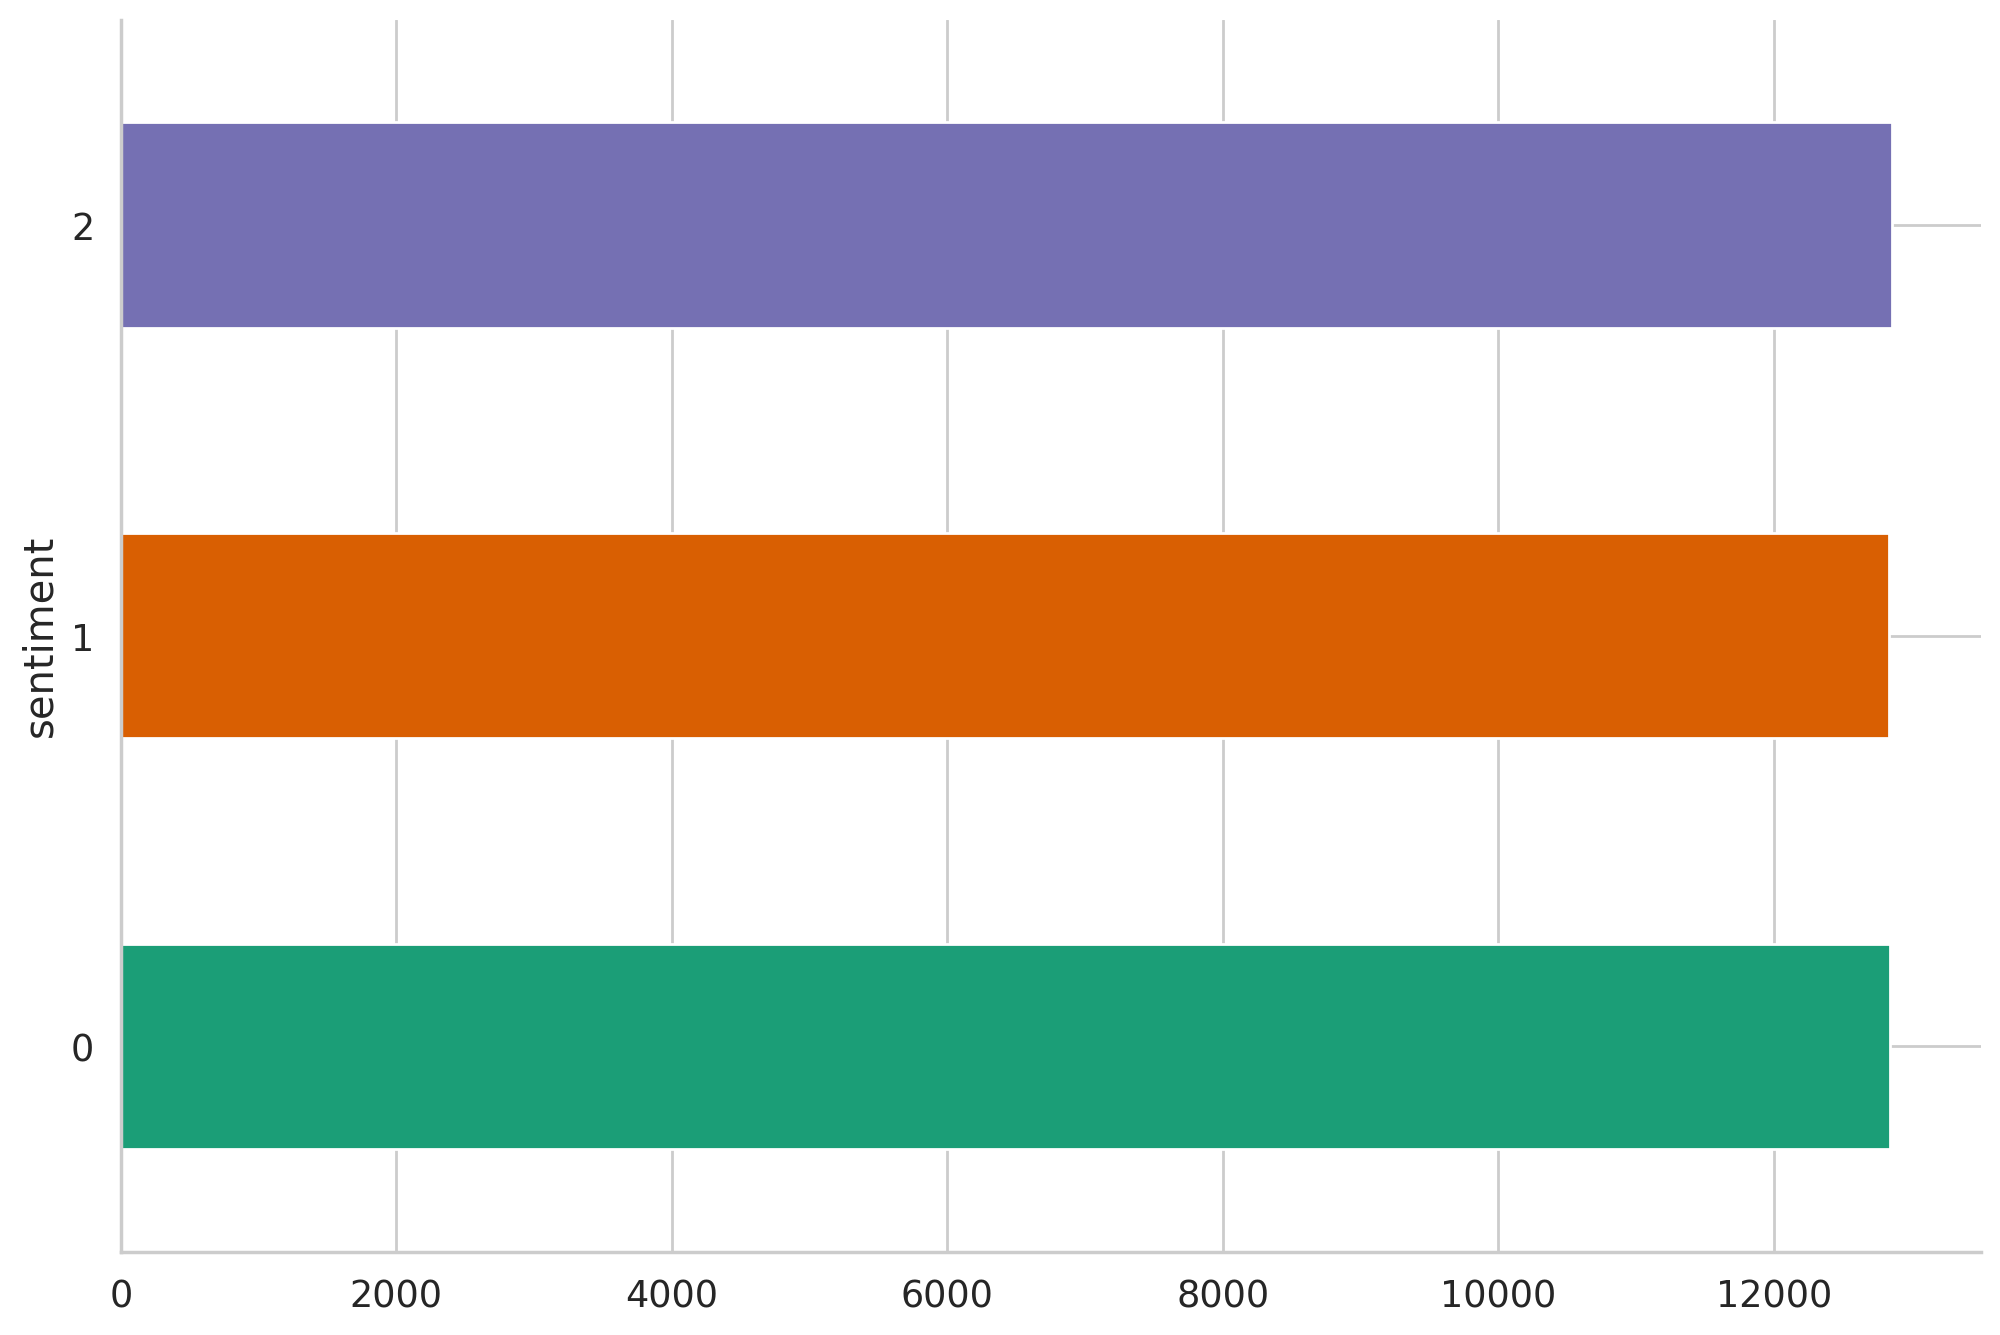

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
class_names = ['Negative', 'Neutral', 'Positive']
df["sentiment"].value_counts()

2    12858
0    12845
1    12838
Name: sentiment, dtype: int64

Text(0.5, 0, 'review sentiment')

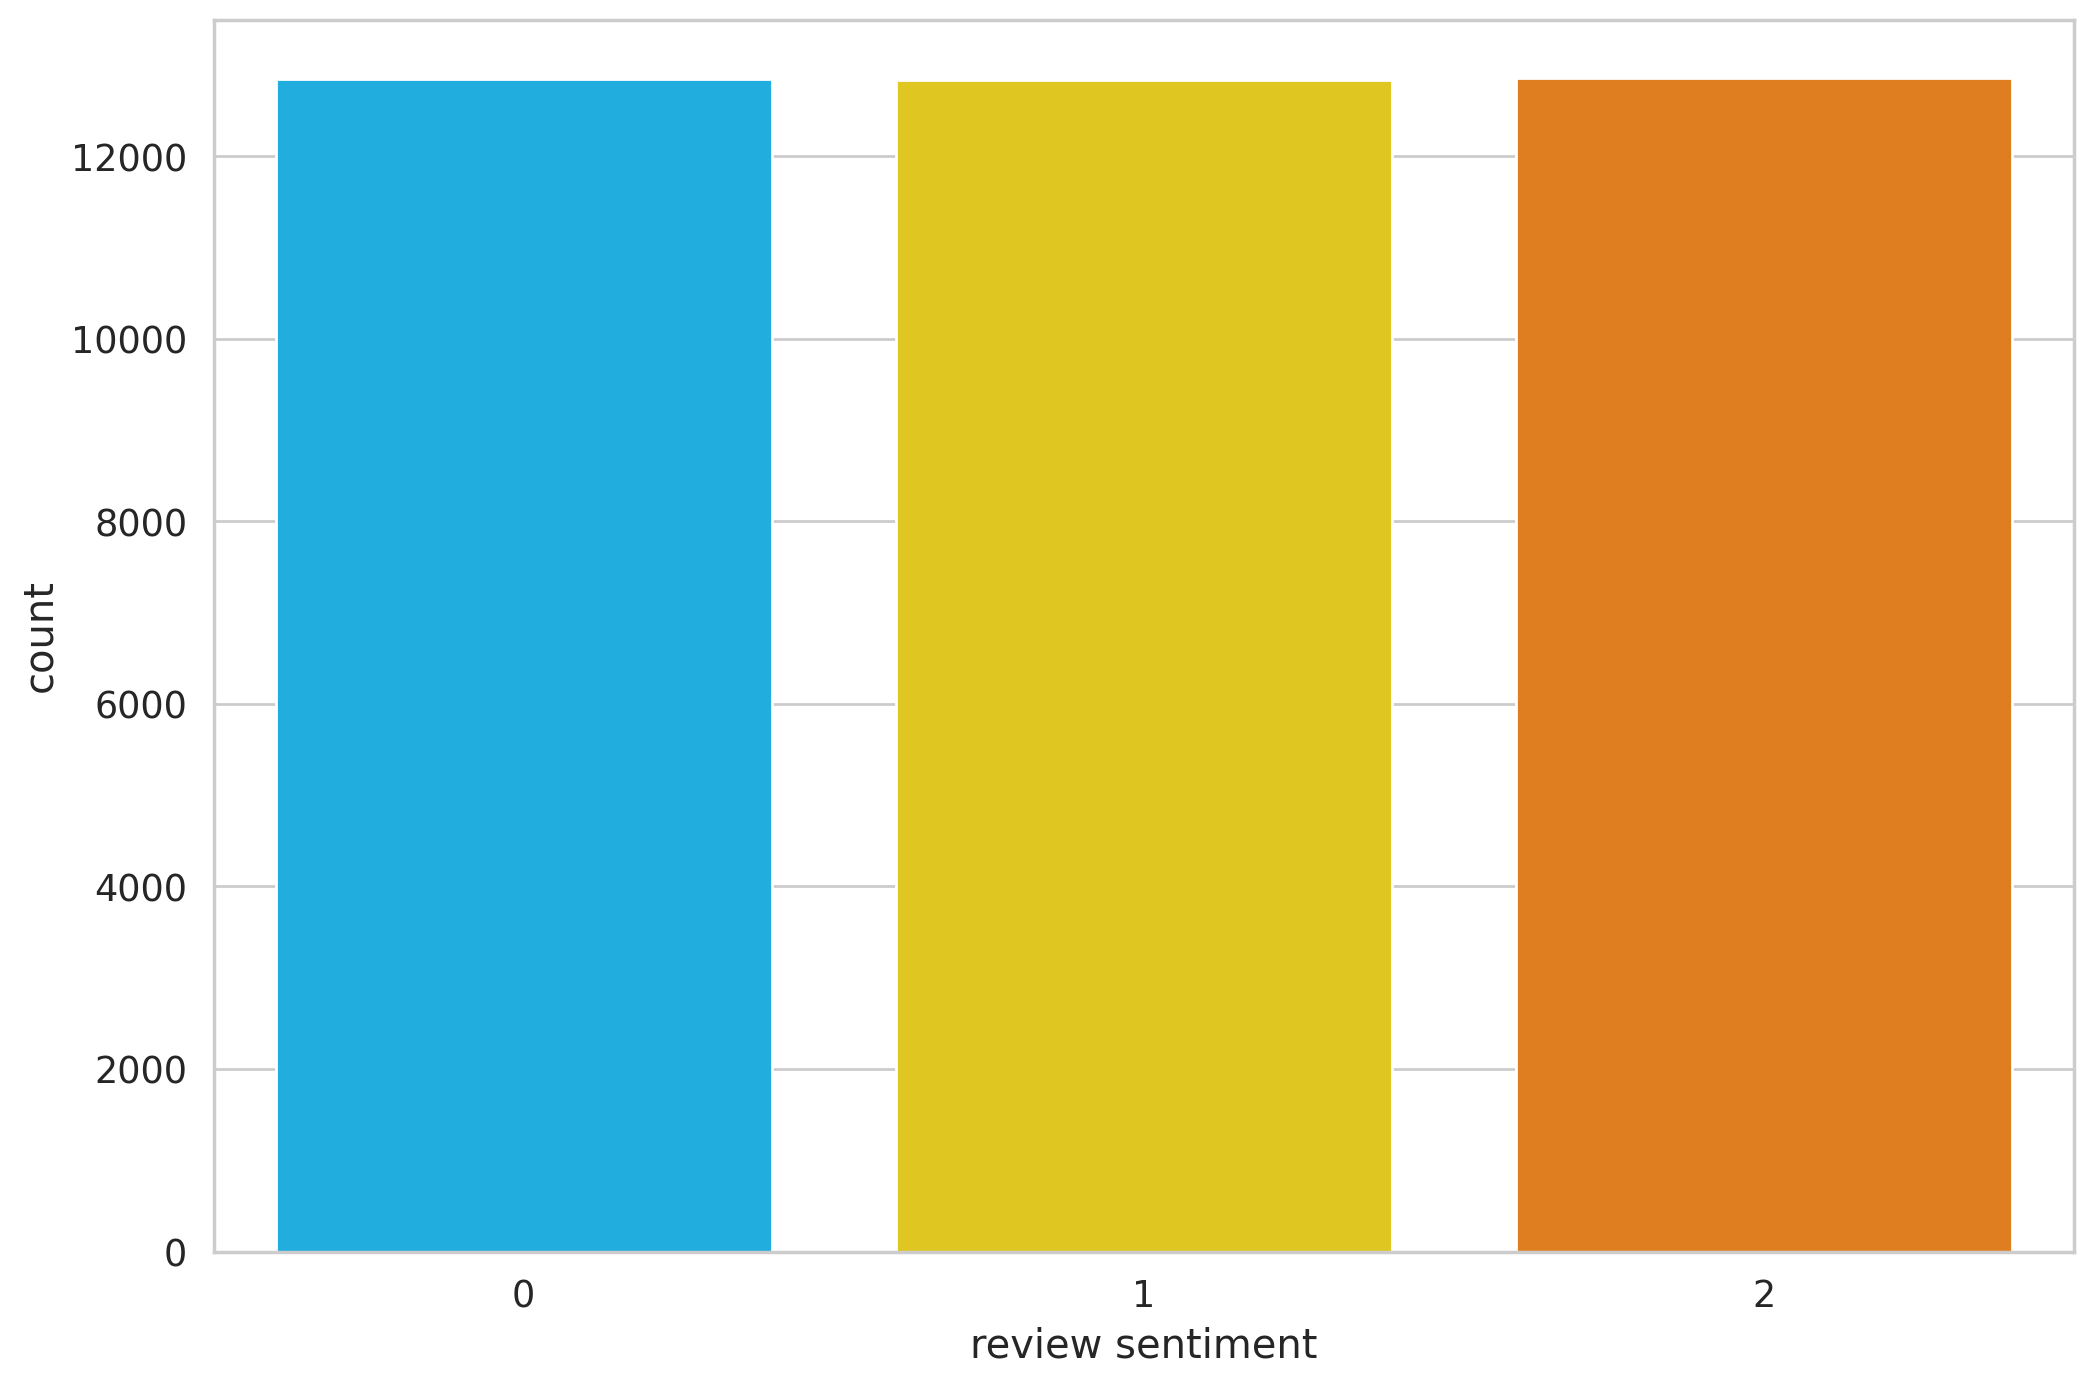

In [ ]:
ax = sns.countplot(x=df.sentiment)
plt.xlabel('review sentiment')
#ax.set_xticklabels(class_names);

The balance was (mostly) restored.

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements:

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'  # E.g., bert-base-uncased, bert-large-cased, bert-large-uncased, etc.

> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll use this text to understand the tokenization process:

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

- The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them. For the BertTokenizer, 1 indicates a value that should be attended to, while 0 indicates a padded value. This attention mask is in the dictionary returned by the tokenizer under the key “attention_mask”:

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,       # 'When was I last outside? I am stuck at home for 2 weeks.' (15 tokens)
  truncation=True,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,   #  used for a pair of sentences, also called segment IDs.
  padding='max_length',          #  Pad to a maximum length
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [ ]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True) # without padding; padding=False
  token_lens.append(len(tokens))

and plot the distribution:

<ipython-input-29-6fcc86d24e23>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)  # or use sns.histplot()


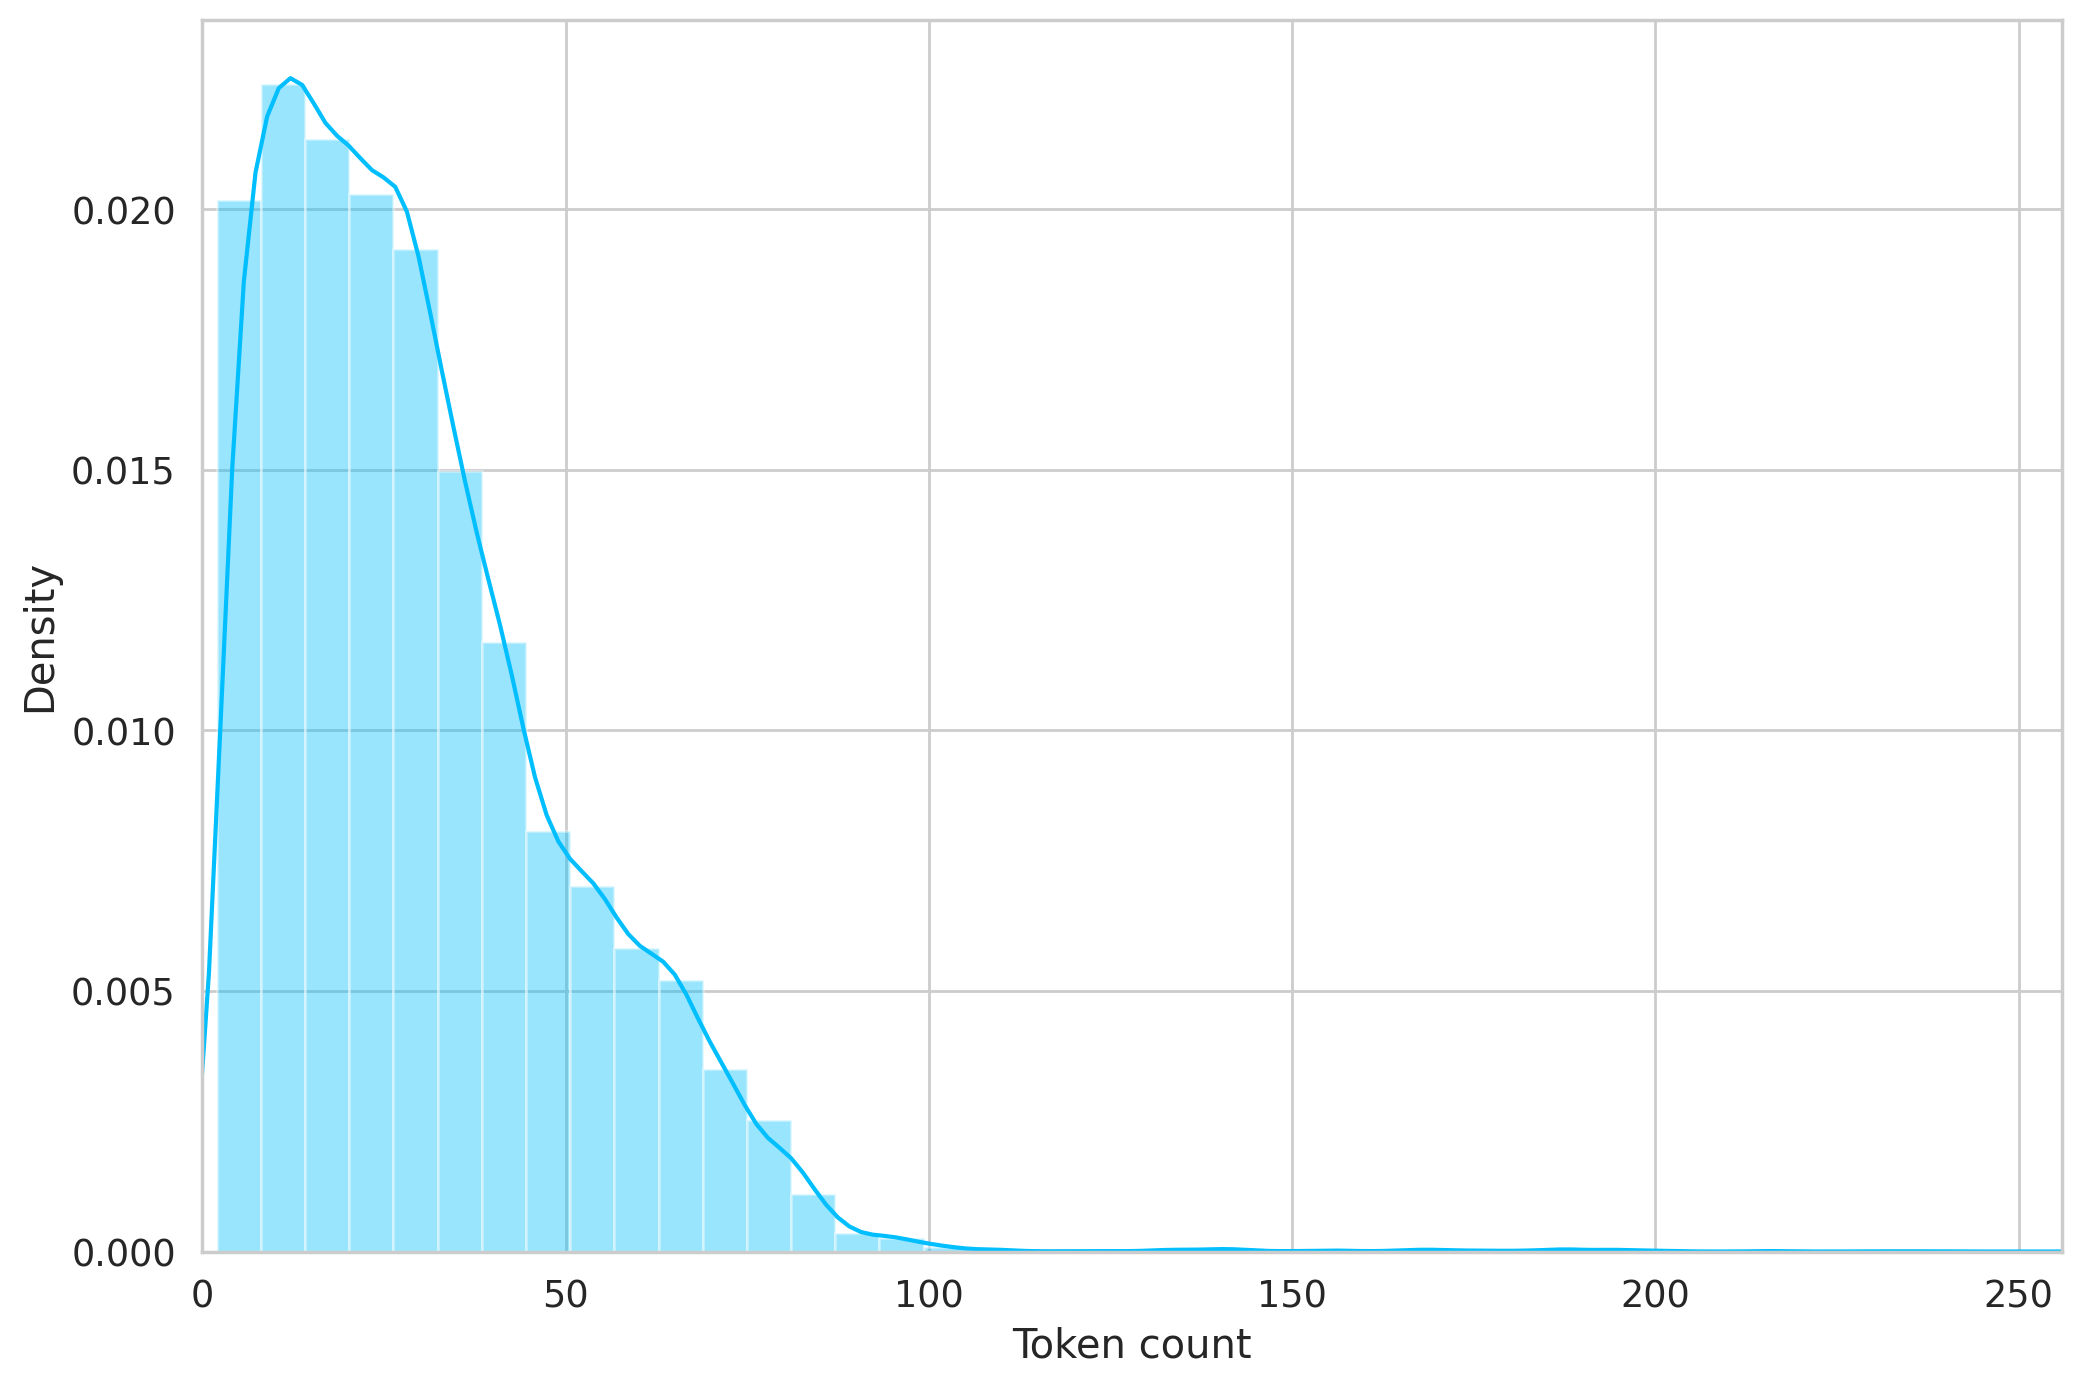

In [ ]:
sns.distplot(token_lens)  # or use sns.histplot()
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 100 tokens, but we'll be on the safe side and choose a maximum length of 120.

In [ ]:
MAX_LEN = 120

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews    # df.content
    self.targets = targets    # df.sentiment
    self.tokenizer = tokenizer
    self.max_len = max_len    # 160

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])    # E.g., "Update: After getting a response from the deve..."
    target = self.targets[item]         # E.g., 0 (negative)

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      truncation=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
                                                                # flatten() flattens input by reshaping it into a one-dimensional tensor.
    return {
      'review_text': review,                                    # "Update: After getting a response from the deve..."
      'input_ids': encoding['input_ids'].flatten(),             # [101, 34, 54, 37, ..., 102, 0, 0, ..., 0]
      'attention_mask': encoding['attention_mask'].flatten(),   # [1,    1,  1,  1, ...,   1, 0, 0, ..., 0]
      'targets': torch.tensor(target, dtype=torch.long)         # 0
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [ ]:
df_train = df[df.split=='train']
df_test = df[df.split=='test']
df_val = df[df.split=='val']


In [ ]:
df_train.shape, df_val.shape, df_test.shape

((26981, 3), (5780, 3), (5780, 3))

We also need to create a couple of data loaders. Here's a helper function to do it:
- Truncation: Truncate to a maximum length specified with the argument max_length or to the maximum acceptable input length for the model if that argument is not provided.

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):  # df is set to df_train, df_val, or df_test
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    #num_workers=4 #  process hangs with num_workers=4
    num_workers=0  #  num_workers: how many subprocesses to use for data loading. 0 means that the data will be
                   #  loaded in the main process. (default: 0)
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)  # MAX_LEN is 160
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))  # first batch from train data
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 120])
torch.Size([16, 120])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And try to use it on the encoding of our sample text: <b>'When was I last outside? I am stuck at home for 2 weeks.'</b>

In [ ]:
outputs = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooler_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [ ]:
outputs.last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [ ]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [ ]:
outputs.pooler_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)  # E.g., hidden_size: 768, n_classes: 3

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,                   # (batch, seq_length), (16, 160)
      attention_mask=attention_mask          # (batch, seq_length), (16, 160)
    )
    output = self.drop(outputs.pooler_output)     # (batch, hidden_size), (16, 768)
    return self.out(output)                       # (batch, 3)

In [ ]:
model = SentimentClassifier(len(class_names))   # class_names = ['negative', 'neutral', 'positive']
model = model.to(device)

We'll move the example batch of our training data to the GPU or CPU:

In [ ]:
input_ids = data['input_ids'].to(device)            # data contains the first batch of train data
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 120])
torch.Size([16, 120])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)  # apply to the model without training

tensor([[0.2699, 0.3781, 0.3520],
        [0.2316, 0.3539, 0.4145],
        [0.3736, 0.2245, 0.4019],
        [0.2088, 0.3555, 0.4357],
        [0.5694, 0.2291, 0.2015],
        [0.2453, 0.4041, 0.3506],
        [0.2633, 0.3205, 0.4162],
        [0.3412, 0.2479, 0.4109],
        [0.3786, 0.2058, 0.4156],
        [0.3434, 0.2091, 0.4475],
        [0.3260, 0.2137, 0.4603],
        [0.3154, 0.2182, 0.4664],
        [0.2291, 0.3839, 0.3870],
        [0.3188, 0.2660, 0.4151],
        [0.3495, 0.2600, 0.3905],
        [0.1538, 0.3741, 0.4721]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps: https://huggingface.co/transformers/main_classes/optimizer_schedules.html
- [get_linear_schedule_with_warmup()](https://huggingface.co/transformers/main_classes/optimizer_schedules.html): Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS       # number of batches in training data * epochs

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):  # with training data

  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # E.g., (16, 3)

    _, preds = torch.max(outputs, dim=1)                                 # E.g., (16, )
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)   # Clips gradients of an iterable of parameters.
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)  # return accuracy and mean loss

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):   # with validation data

  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc.cpu().detach().numpy())
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc.cpu().detach().numpy())
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'gdrive/My Drive/Colab Notebooks/Twitter project/model_storage/BERT/best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.27507063114345426 accuracy 0.9070456988250991
Val   loss 0.40211705461103286 accuracy 0.878719723183391

Epoch 2/10
----------
Train loss 0.1572171670687509 accuracy 0.9527815870427337
Val   loss 0.4421425803856492 accuracy 0.9032871972318339

Epoch 3/10
----------
Train loss 0.10632689693906713 accuracy 0.9681257180979207
Val   loss 0.48035268238541423 accuracy 0.9089965397923875

Epoch 4/10
----------
Train loss 0.08307656640120556 accuracy 0.9745005744783365
Val   loss 0.46949965617266026 accuracy 0.9122837370242214

Epoch 5/10
----------
Train loss 0.0596693785711544 accuracy 0.9799859160149734
Val   loss 0.5145097756062292 accuracy 0.9122837370242214

Epoch 6/10
----------
Train loss 0.0503982692648479 accuracy 0.9815796301100774
Val   loss 0.5154293357197943 accuracy 0.9141868512110727

Epoch 7/10
----------
Train loss 0.04199504906121482 accuracy 0.9839146065749972
Val   loss 0.527875411828455 accuracy 0.9160899653979239

Epoch 8/10
----------


Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

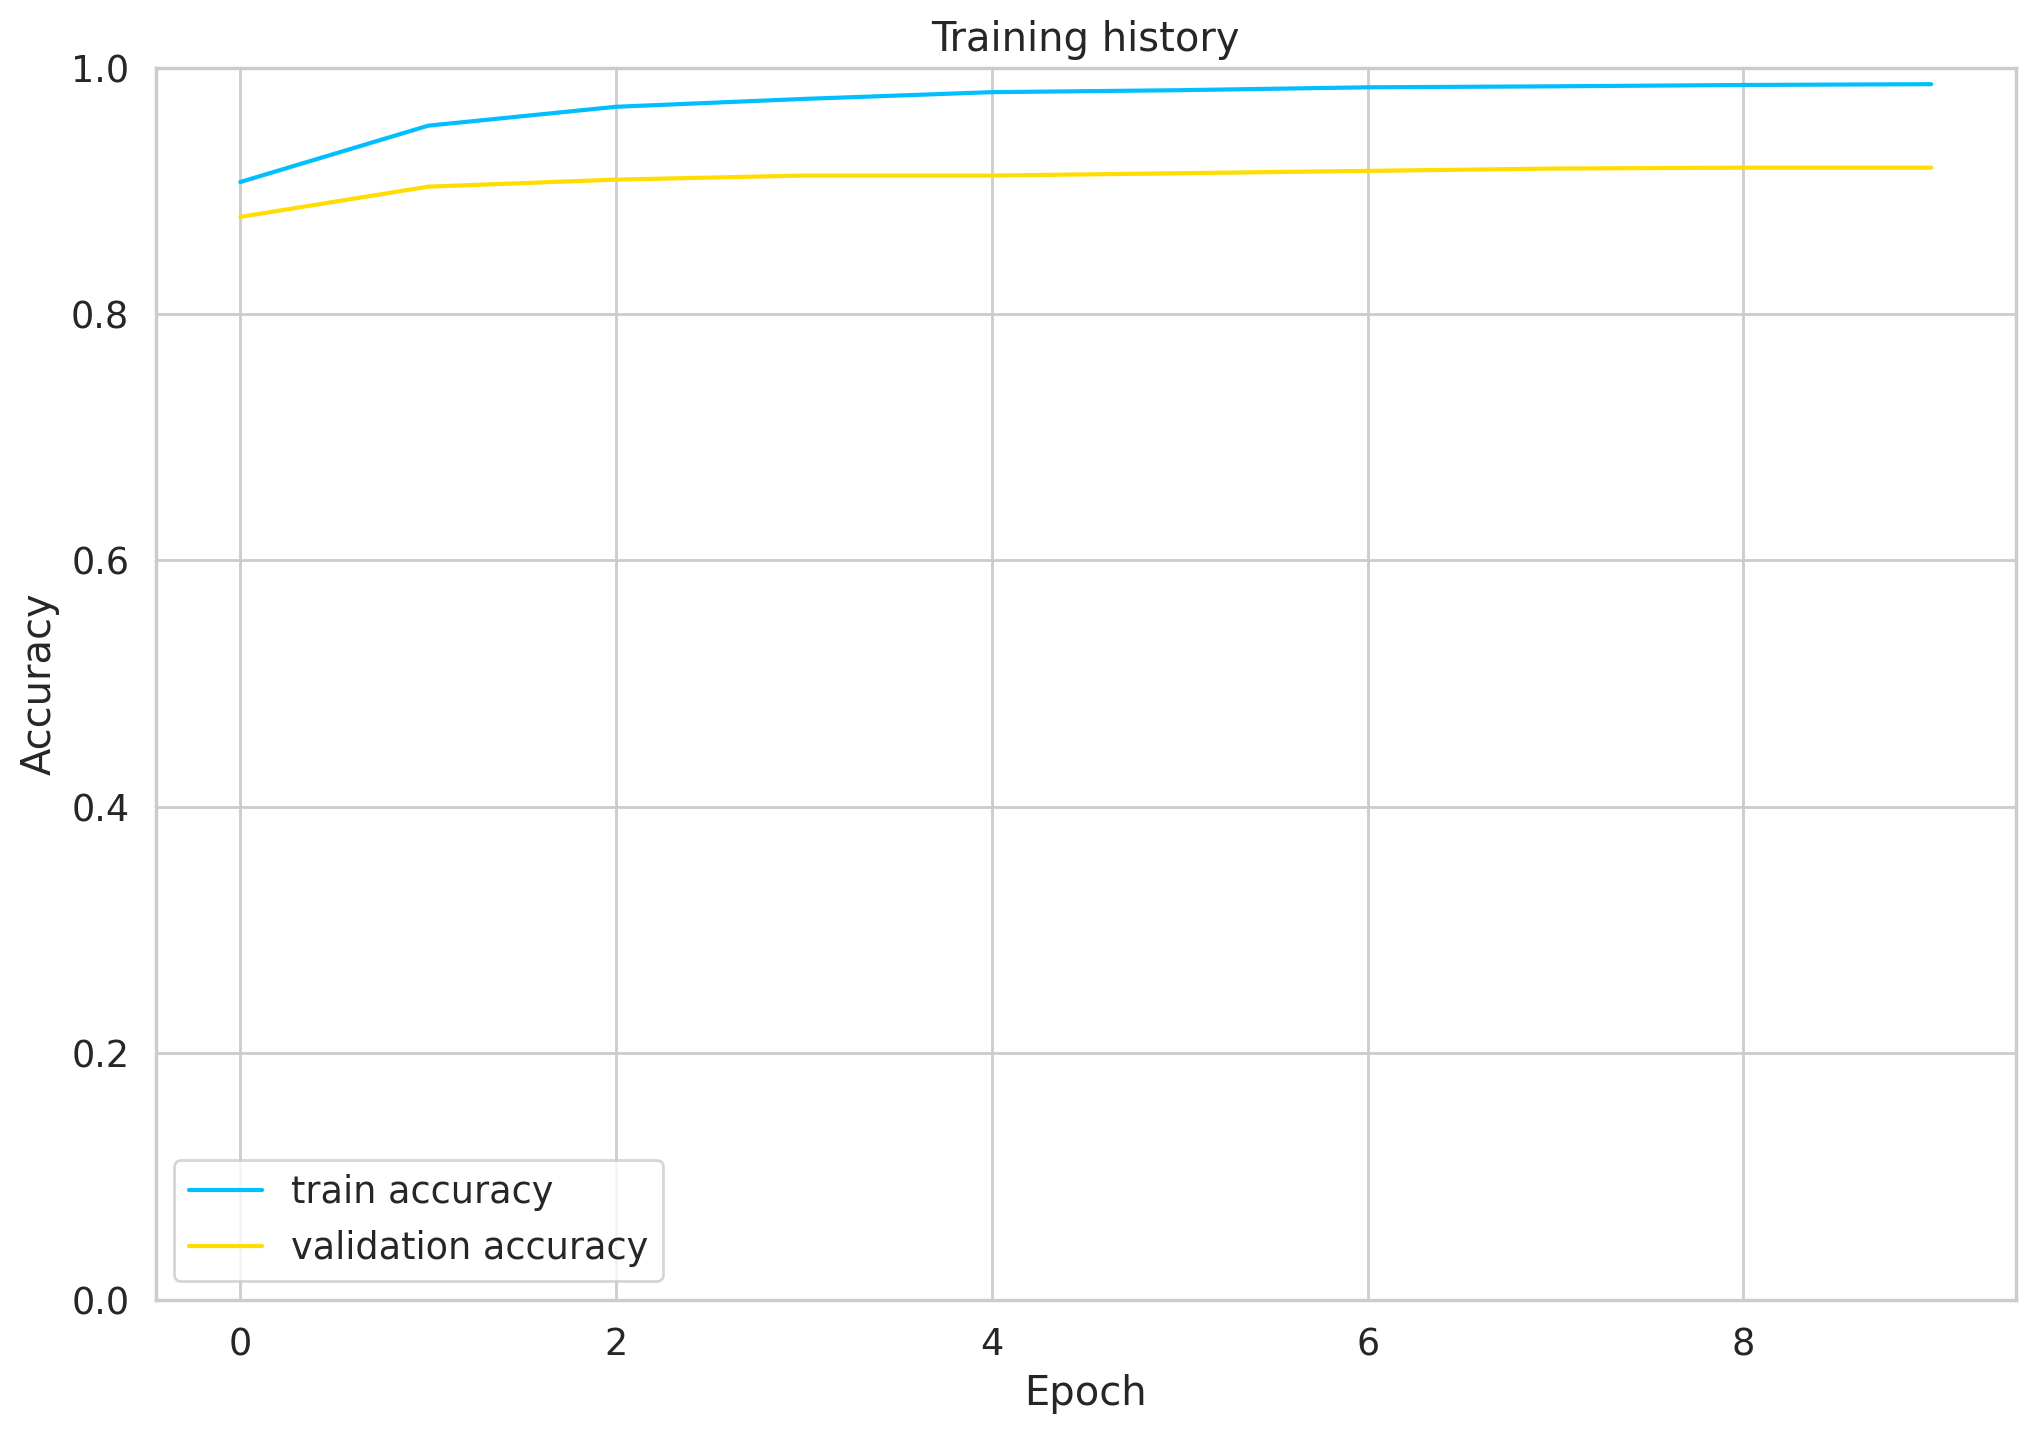

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# possible to use a local machine with the pre-trained model, instead of using colab

#model.load_state_dict(torch.load('model/best_model_state.bin', map_location=torch.device('cpu'))) # uncomment this line for a cpu machine

model.load_state_dict(torch.load('gdrive/My Drive/Colab Notebooks/Twitter project/model_storage/BERT/best_model_state.bin')) # comment this line if you uncommented above line
model = model.to(device)

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

test_acc.item()

0.9209342560553633

In [ ]:
def get_predictions(model, data_loader):

  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)   # E.g., (16, 3)
      _, preds = torch.max(outputs, dim=1)                                  # E.g., (16,)

      probs = F.softmax(outputs, dim=1)                                     # E.g., (16, 3)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()             # E.g., (788,)
  prediction_probs = torch.stack(prediction_probs).cpu()   # E.g., prediction_probs.shape: (788, 3)
  real_values = torch.stack(real_values).cpu()             # E.g., (788,)
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader) # E.g., y_pred_probs.shape: (788, 3)

Let's have a look at the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names)) # E.g., len(y_test): 788; len(y_pred): 788

              precision    recall  f1-score   support

    Negative       0.94      0.92      0.93      1931
     Neutral       0.91      0.93      0.92      1922
    Positive       0.92      0.92      0.92      1927

    accuracy                           0.92      5780
   macro avg       0.92      0.92      0.92      5780
weighted avg       0.92      0.92      0.92      5780



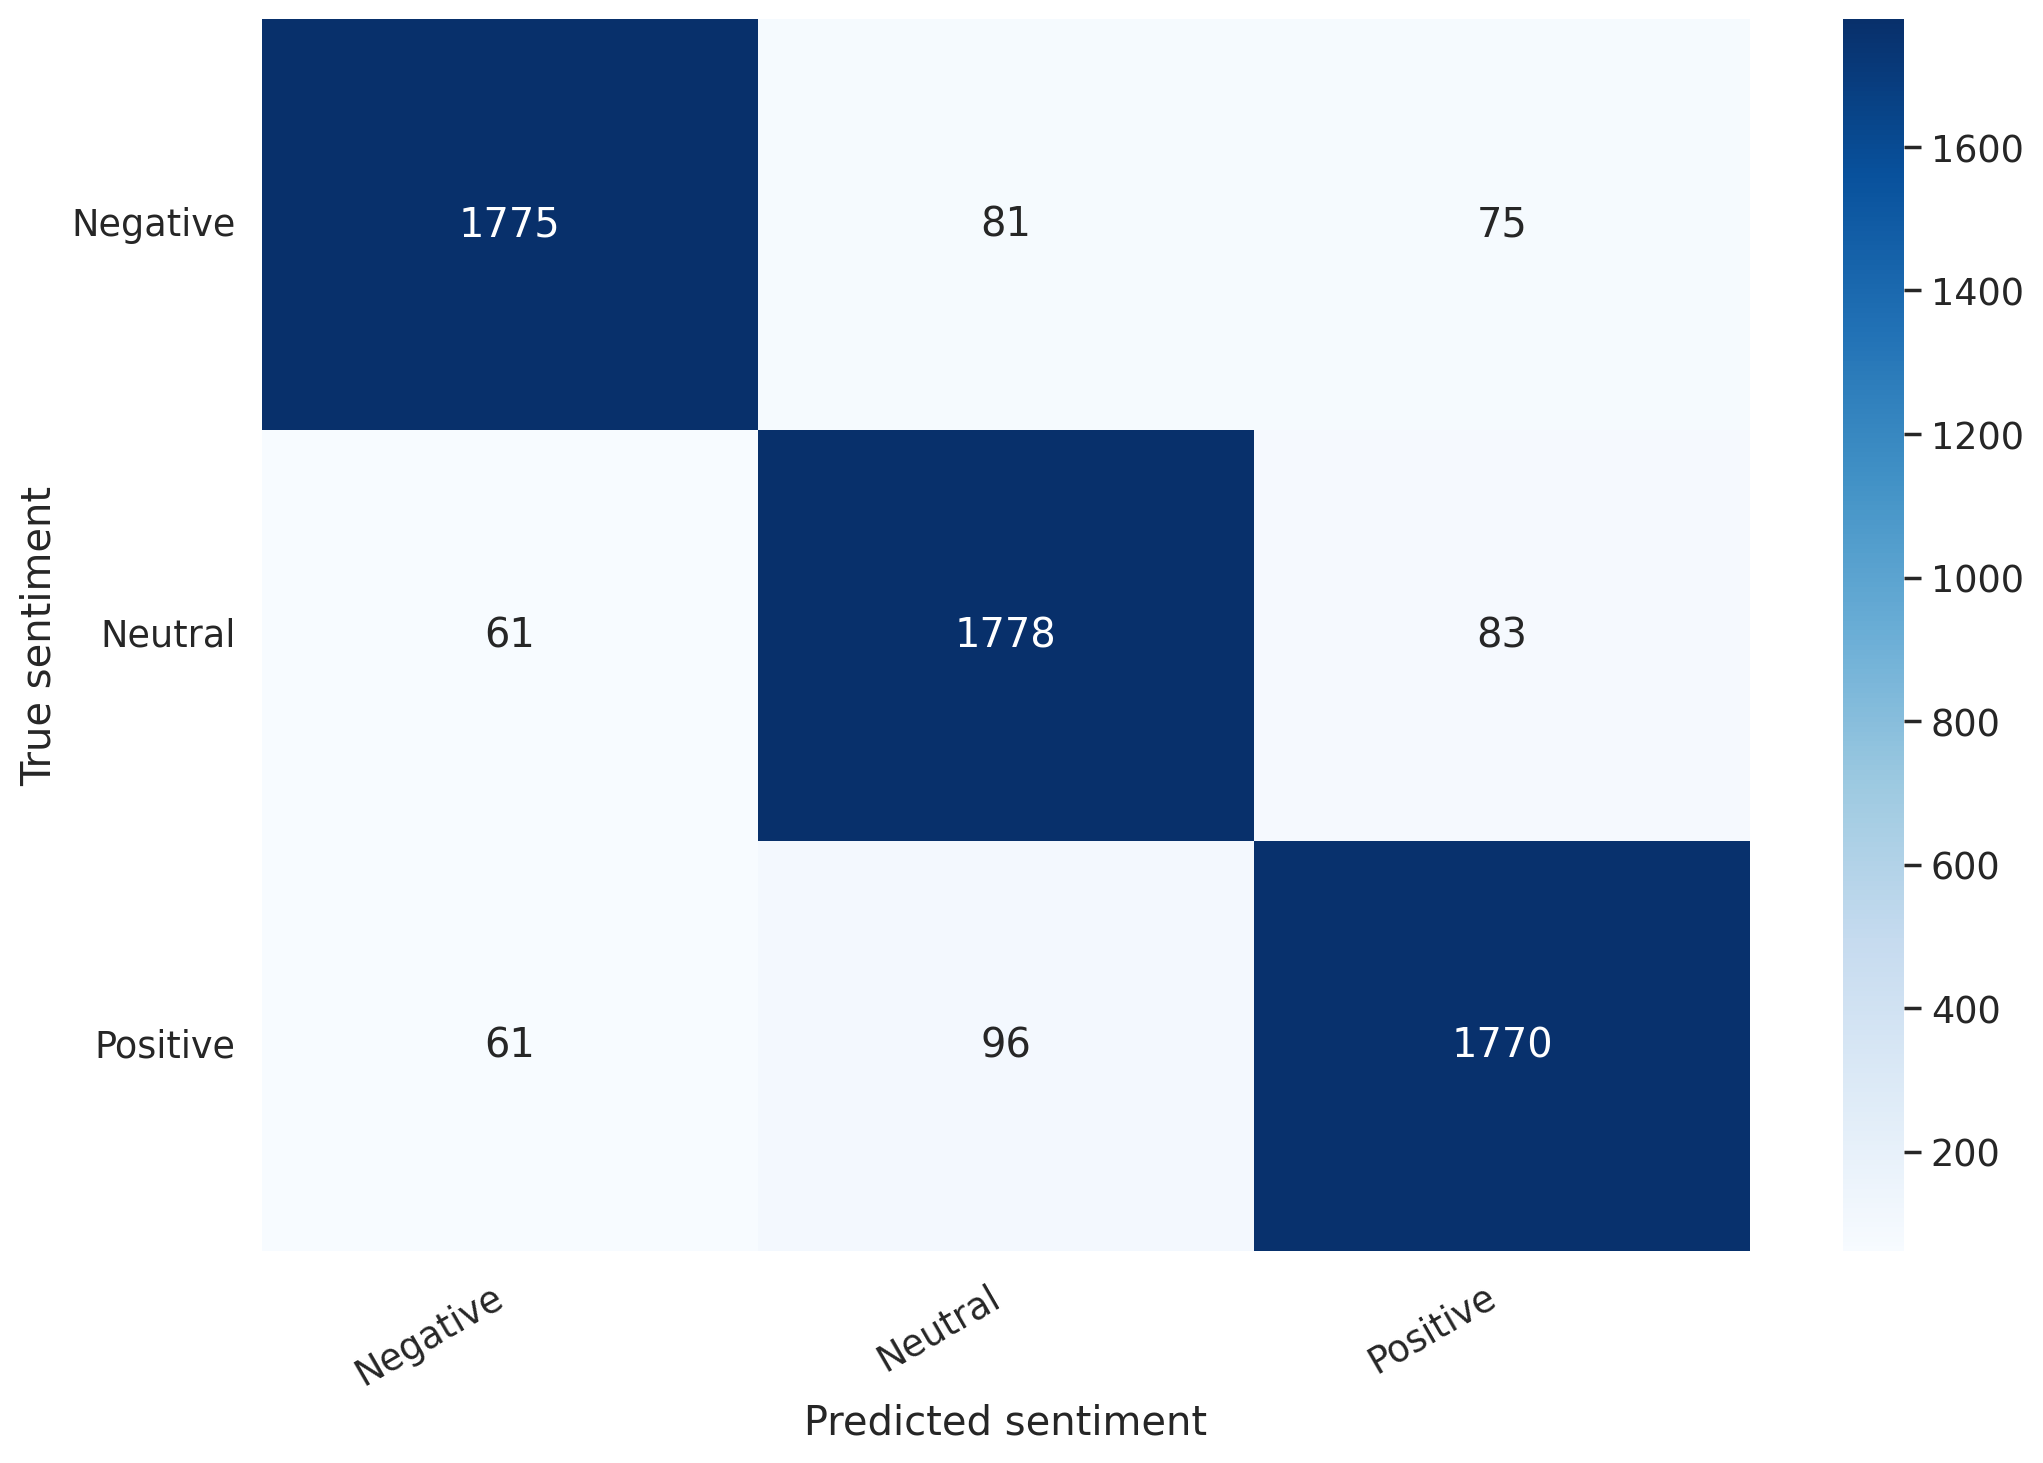

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

review_text = y_review_texts[idx]     # review text in test data
true_sentiment = y_test[idx]          # true sentiment
pred_df = pd.DataFrame({
  'class_names': class_names,         # class_names = ['negative', 'neutral', 'positive']
  'values': y_pred_probs[idx]         #         E.g., [0.0, 1.0, 0.0]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

screenwriter chat with woodsholefilmfestival went great ! to hear what
we all had to say about our work , visit the woods hole film festival
facebook page . it s an honor to be a part of it , thank you ! . . . .
. . .

True sentiment: Neutral


Now we can look at the confidence of each sentiment of our model:

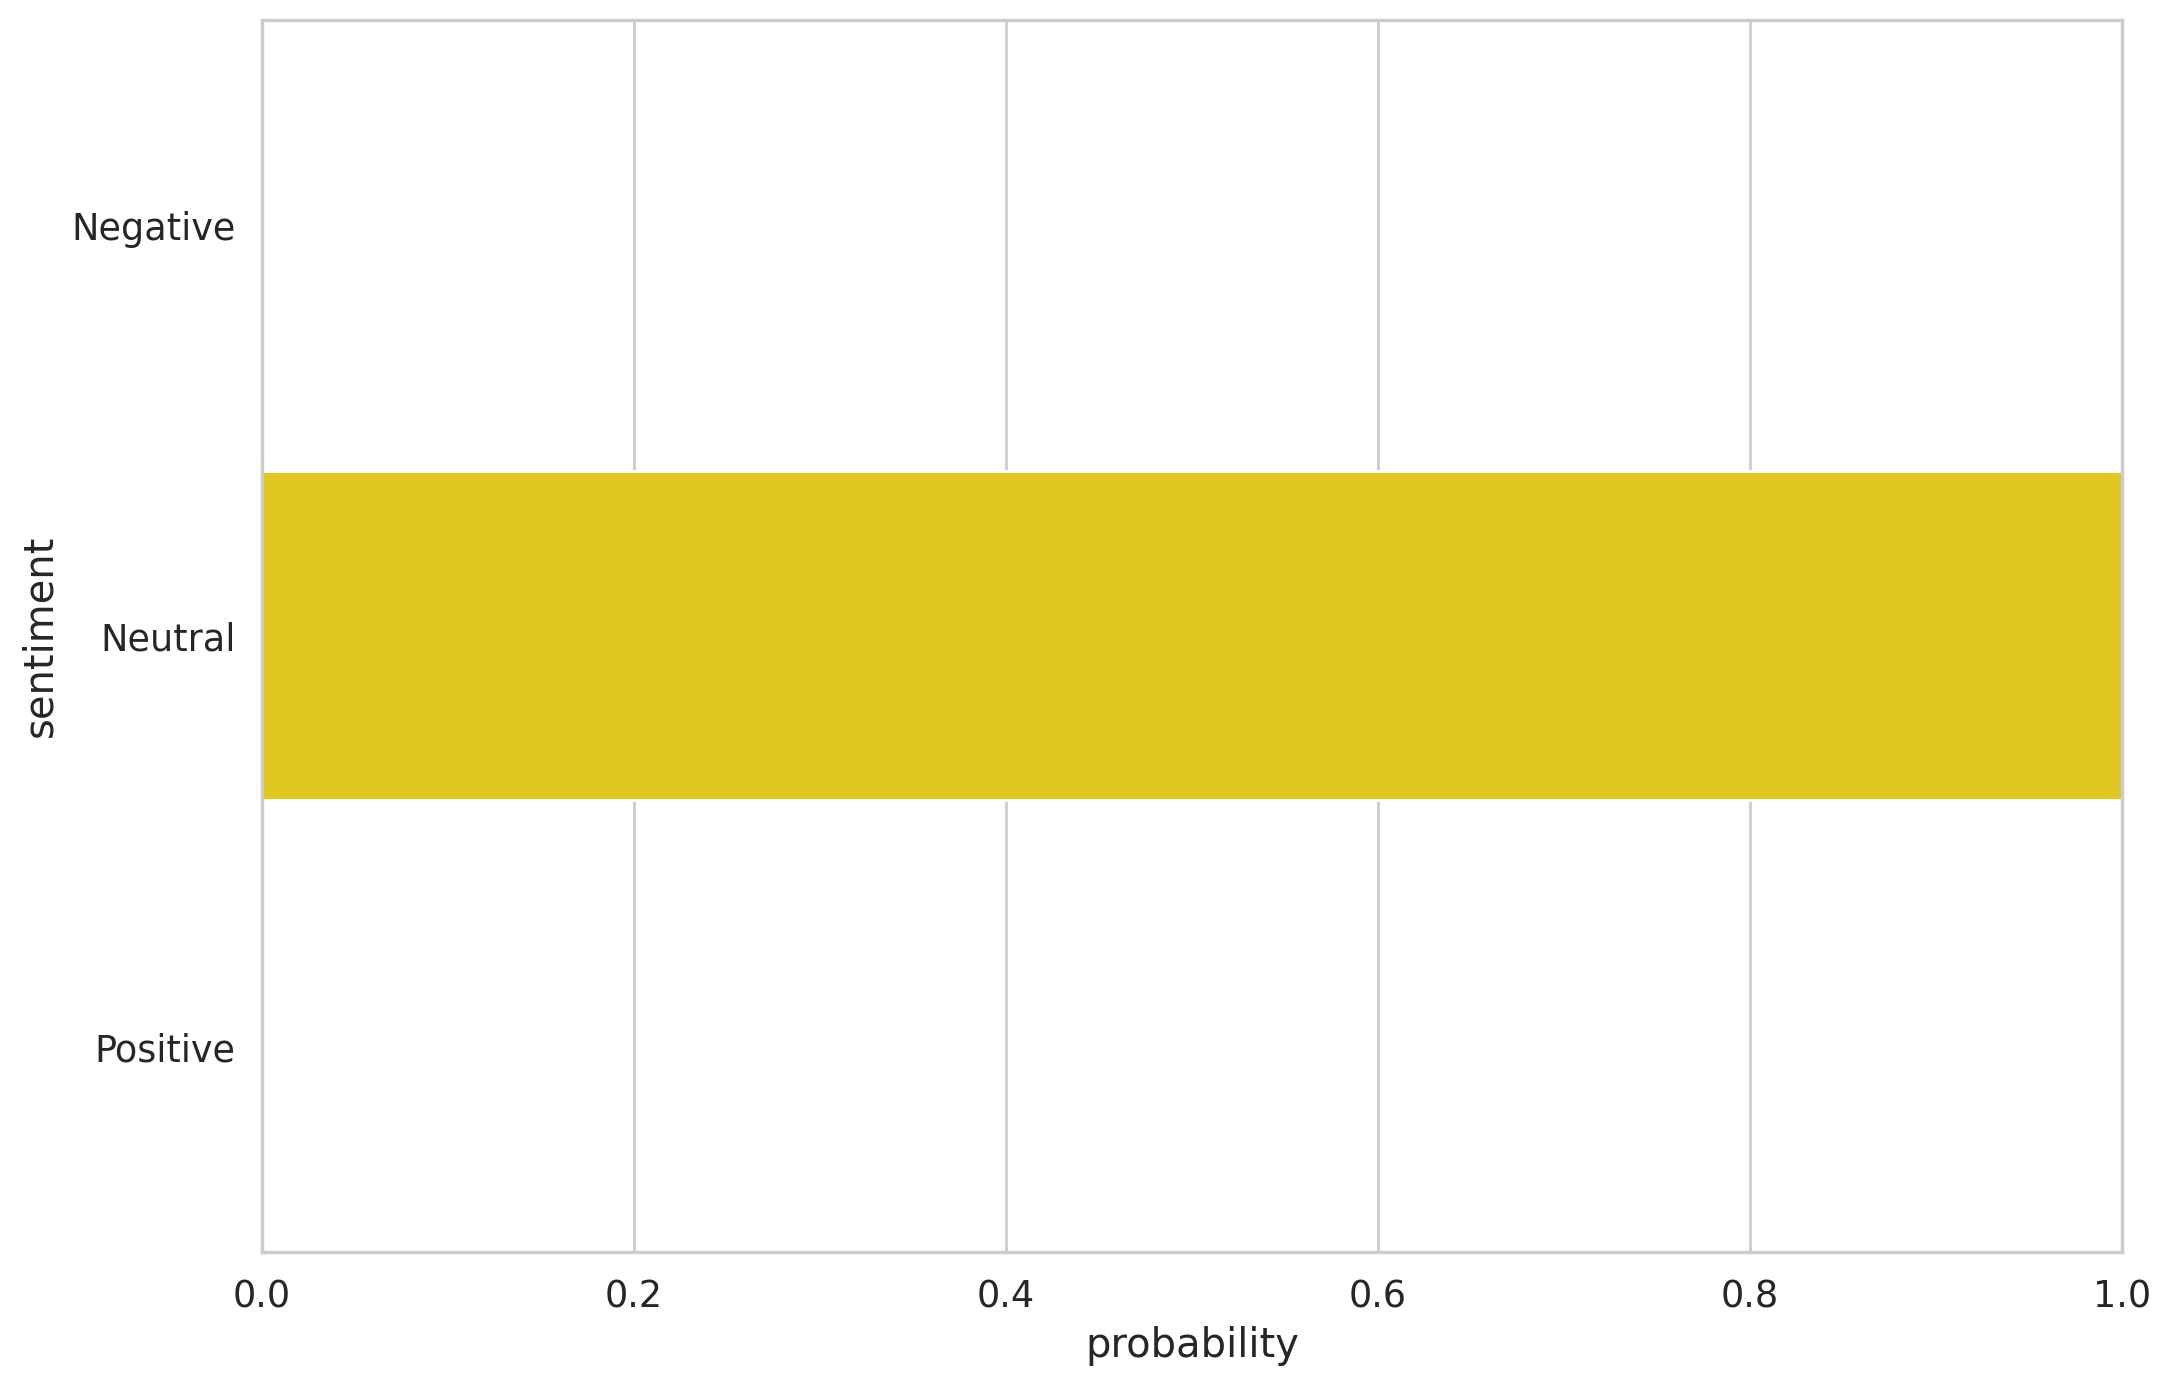

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

We have to use the tokenizer to encode the text:

- truncation: Truncate to a maximum length specified with the argument max_length or to the maximum acceptable input length for the model if that argument is not provided.

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : Positive
